In [43]:
!pip install python-bidi catboost --quiet


# Imported Libraries

In [44]:

import sklearn
import xgboost
import catboost
import numpy as np
import pandas as pd

print("scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)
print("CatBoost version:", catboost.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


scikit-learn version: 1.2.2
XGBoost version: 2.0.3
CatBoost version: 1.2.7
NumPy version: 1.26.4
Pandas version: 2.2.3


In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from bidi.algorithm import get_display
from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Auxillary Functions


In [46]:
# Initialize a dictionary to store model results
model_performance = {
    'Model': [],
    'Train_RMSPE': [],
    'Test_RMSPE': [],
    'Train_R2': [],
    'Test_R2': []
}


def fill_missing_values(df):
    quantitative_cols = df.select_dtypes(include=np.number).columns
    df[quantitative_cols] = df[quantitative_cols].fillna(df[quantitative_cols].mean())
    return df


def handle_categorical_data(df):
    enc = OrdinalEncoder()
    categorical_cols = df.select_dtypes(include="object").columns.tolist()
    df[categorical_cols] = enc.fit_transform(df[categorical_cols])
    return df


def clip_outliers(df, multiplier=1.5, columns_to_clip=None):
    if columns_to_clip is None:
        columns_to_clip = df.select_dtypes(include=np.number).columns
    for column in columns_to_clip:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr
        df[column] = df[column].clip(lower_bound, upper_bound)
    return df


class Enums(object):
    A = 'P'
    B = 'FP'
    X1 = 'SE'
    X2 = 'DM'
    X3 = 'PH'
    X4 = 'SM'
    X5 = 'SP'
    X6 = 'TW'
    X7 = 'SY'
    X8 = 'BY'
    X9 = 'PP'
    X10 = 'PY'
    X11 = 'HI'


rename_dict = {
    'A': Enums.A,
    'B': Enums.B,
    'X1': Enums.X1,
    'X2': Enums.X2,
    'X3': Enums.X3,
    'X4': Enums.X4,
    'X5': Enums.X5,
    'X6': Enums.X6,
    'X7': Enums.X7,
    'X8': Enums.X8,
    'X9': Enums.X9,
    'X10': Enums.X10,
    'X11': Enums.X11
}


def remove_uncorrelated_features(df, threshold=0.05):
    df.rename(columns=rename_dict, inplace=True)

    features_to_exclude = ['rep']
    numeric_columns = df.drop(columns=[col for col in features_to_exclude if col in df.columns]).select_dtypes(include=np.number).columns
    corr_matrix = df[numeric_columns].corr(method="spearman")

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
        annot_kws={"size": 14, "color": "black"}
    )

    plt.xlabel("", fontsize=14, weight='bold')
    plt.ylabel("", fontsize=14, weight='bold')

    plt.show()

    return df

def preprocess_data(df):
    df = fill_missing_values(df)
    df = handle_categorical_data(df)
    df = clip_outliers(df)
    df = remove_uncorrelated_features(df)
    return df


def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.grid(True)
    plt.show()


def rmspe(y_true, y_pred):
    epsilon = 1e-10
    return np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + epsilon)))) * 100


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_rmspe = rmspe(y_train, y_pred_train)
    test_rmspe = rmspe(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"Model: {model_name}")
    print(f"Train RMSPE: {train_rmspe:.4f}%")
    print(f"Test RMSPE: {test_rmspe:.4f}%")
    print(f"Train R^2: {train_r2:.4f}")
    print(f"Test R^2: {test_r2:.4f}")
    print('-' * 30)

    # Store model performance metrics
    model_performance['Model'].append(model_name)
    model_performance['Train_RMSPE'].append(train_rmspe)
    model_performance['Test_RMSPE'].append(test_rmspe)
    model_performance['Train_R2'].append(train_r2)
    model_performance['Test_R2'].append(test_r2)

    return model

# Loading and Describing the Dataset


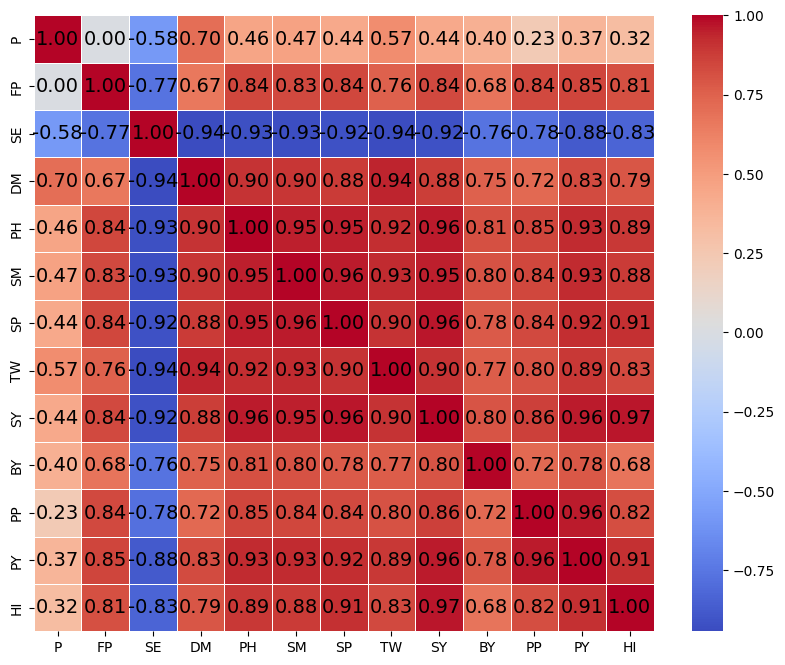

In [47]:
# Load and preprocess data
data = pd.read_csv("/kaggle/input/rainfedwheat/x11.csv")

data = preprocess_data(data)

imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

#Change Here for diffrent Trait's results
X = data_imputed.drop('PH', axis=1)
y = data_imputed['PH']

# Train-test split and preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
# Display first few rows and general information
print("First few rows of the dataset:")
print(data.head())
print("\nGeneral information about the dataset:")
print(data.info())

First few rows of the dataset:
   P  FP   SE   DM    PH   SM  SP    TW    SY      BY    PP       PY  \
0  1   1  153  171  78.6  256  36  38.3  1372  4027.0   9.3  127.596   
1  1   2  150  173  79.7  267  39  39.7  1389  4065.0   9.5  131.955   
2  1   3  148  176  82.5  288  45  40.6  1526  4280.0  11.1  169.386   
3  1   4  145  180  83.1  291  48  41.2  1559  4347.0  11.4  177.726   
4  1   5  143  182  83.8  294  51  42.7  1582  4384.0  11.6  183.512   

          HI  
0  34.070027  
1  34.169742  
2  35.654206  
3  35.863814  
4  36.085766  

General information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P       80 non-null     int64  
 1   FP      80 non-null     int64  
 2   SE      80 non-null     int64  
 3   DM      80 non-null     int64  
 4   PH      80 non-null     float64
 5   SM      80 non-null     int64  
 6   SP

# **Evaluate multiple models**

#  Linear Regression

In [49]:
# Linear Regression
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
lin_reg = LinearRegression()
evaluate_model(lin_reg, X_train_pca, y_train, X_test_pca, y_test, 'LR')

Model: LR
Train RMSPE: 1.0128%
Test RMSPE: 1.2296%
Train R^2: 0.9007
Test R^2: 0.8840
------------------------------


LinearRegression()

#  Ridge Regression

In [50]:
# Ridge Regression
ridge_params = {'alpha': np.logspace(-4, 4, 50)}  # 50 values from 10^-4 to 10^4
ridge_reg = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_reg.fit(X_train, y_train)
evaluate_model(ridge_reg, X_train, y_train, X_test, y_test, 'Ridge')

Model: Ridge
Train RMSPE: 0.2462%
Test RMSPE: 0.3462%
Train R^2: 0.9941
Test R^2: 0.9907
------------------------------


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.68511...
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])},
             scoring='r2')

# Lasso Regression

In [51]:
# Lasso Regression
lasso_params = {'alpha': np.logspace(-4, 4, 50)}
lasso_reg = GridSearchCV(Lasso(max_iter=100000), lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_reg.fit(X_train, y_train)
evaluate_model(lasso_reg, X_train, y_train, X_test, y_test, 'Lasso')

Model: Lasso
Train RMSPE: 0.2669%
Test RMSPE: 0.3301%
Train R^2: 0.9930
Test R^2: 0.9918
------------------------------


GridSearchCV(cv=5, estimator=Lasso(max_iter=100000), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362...
       8.28642773e-01, 1.20679264e+00, 1.75751062e+00, 2.55954792e+00,
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])},
             scoring='r2')

# ElasticNet Regression

In [52]:
# ElasticNet Regression
elastic_net_params = {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]}
elastic_net_reg = RandomizedSearchCV(ElasticNet(), elastic_net_params, cv=3, scoring='r2', n_iter=4, random_state=42,
                                     n_jobs=-1)
elastic_net_reg.fit(X_train, y_train)
evaluate_model(elastic_net_reg, X_train, y_train, X_test, y_test, 'EN')

Model: EN
Train RMSPE: 0.2901%
Test RMSPE: 0.4052%
Train R^2: 0.9918
Test R^2: 0.9872
------------------------------


RandomizedSearchCV(cv=3, estimator=ElasticNet(), n_iter=4, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.1, 1.0],
                                        'l1_ratio': [0.1, 0.5, 0.9]},
                   random_state=42, scoring='r2')

# SVR

In [53]:
# SVR
svr_params = {'C': [1.0, 10.0, 100], 'gamma': ['scale', 'auto'], 'epsilon': [0.1, 0.2,0.5], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
svr_reg = RandomizedSearchCV(SVR(kernel='rbf'), svr_params, cv=3, scoring='r2', n_iter=10, random_state=42, n_jobs=-1)
svr_reg.fit(X_train, y_train)
evaluate_model(svr_reg, X_train, y_train, X_test, y_test, 'SVR')

Model: SVR
Train RMSPE: 0.2731%
Test RMSPE: 0.3800%
Train R^2: 0.9929
Test R^2: 0.9888
------------------------------


RandomizedSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
                   param_distributions={'C': [1.0, 10.0, 100],
                                        'epsilon': [0.1, 0.2, 0.5],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='r2')

#  Random Forest

In [54]:
# Random Forest
rf_params = {
    'n_estimators': [50, 60, 80, 100, 200, 300],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [3, 5, 7, 9, 11],
    'max_features': ['sqrt', 'log2', None],
}
rf_reg = RandomizedSearchCV(
    RandomForestRegressor(),
    rf_params,
    cv=5,
    scoring='r2',
    n_iter=10,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)
evaluate_model(rf_reg, X_train, y_train, X_test, y_test, 'RF')

Model: RF
Train RMSPE: 1.2792%
Test RMSPE: 1.7965%
Train R^2: 0.8674
Test R^2: 0.7929
------------------------------


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      10, 15, 20],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [3, 5, 7, 9, 11],
                                        'min_samples_split': [2, 3, 4, 5, 6],
                                        'n_estimators': [50, 60, 80, 100, 200,
                                                         300]},
                   random_state=42, scoring='r2')

# XGBoost

In [55]:
# XGBoost
xgb_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'booster': ['gbtree', 'dart'],
}

xgb_reg = RandomizedSearchCV(
    xgb.XGBRegressor(),
    xgb_params,
    n_iter=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)
xgb_reg.fit(X_train, y_train)
evaluate_model(xgb_reg, X_train, y_train, X_test, y_test, 'XGB')

Model: XGB
Train RMSPE: 0.0020%
Test RMSPE: 0.5766%
Train R^2: 1.0000
Test R^2: 0.9739
------------------------------


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='r2')

# CatBoost Regressor

In [56]:
# CatBoost Regressor
catboost_params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 10, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 50, 100],  # Use this parameter
    # 'max_bin': [128, 254],         # Uncomment this line to use max_bin instead
}
catboost_reg = RandomizedSearchCV(CatBoostRegressor(verbose=0), catboost_params, cv=3, scoring='r2', n_iter=10, random_state=42, n_jobs=-1)
catboost_reg.fit(X_train, y_train)
evaluate_model(catboost_reg, X_train, y_train, X_test, y_test, 'CatBoost')


# Display model performance summary
model_performance_df = pd.DataFrame(model_performance)
print(model_performance_df)
# Plot the model comparison
model_performance_df = pd.DataFrame(model_performance)

Model: CatBoost
Train RMSPE: 0.2052%
Test RMSPE: 0.7581%
Train R^2: 0.9960
Test R^2: 0.9573
------------------------------
      Model  Train_RMSPE  Test_RMSPE  Train_R2   Test_R2
0        LR     1.012800    1.229649  0.900666  0.883955
1     Ridge     0.246166    0.346165  0.994131  0.990677
2     Lasso     0.266877    0.330054  0.993021  0.991762
3        EN     0.290116    0.405189  0.991809  0.987232
4       SVR     0.273058    0.380027  0.992856  0.988809
5        RF     1.279228    1.796467  0.867422  0.792897
6       XGB     0.002038    0.576551  1.000000  0.973893
7  CatBoost     0.205193    0.758127  0.995992  0.957331


# Plotting The Results

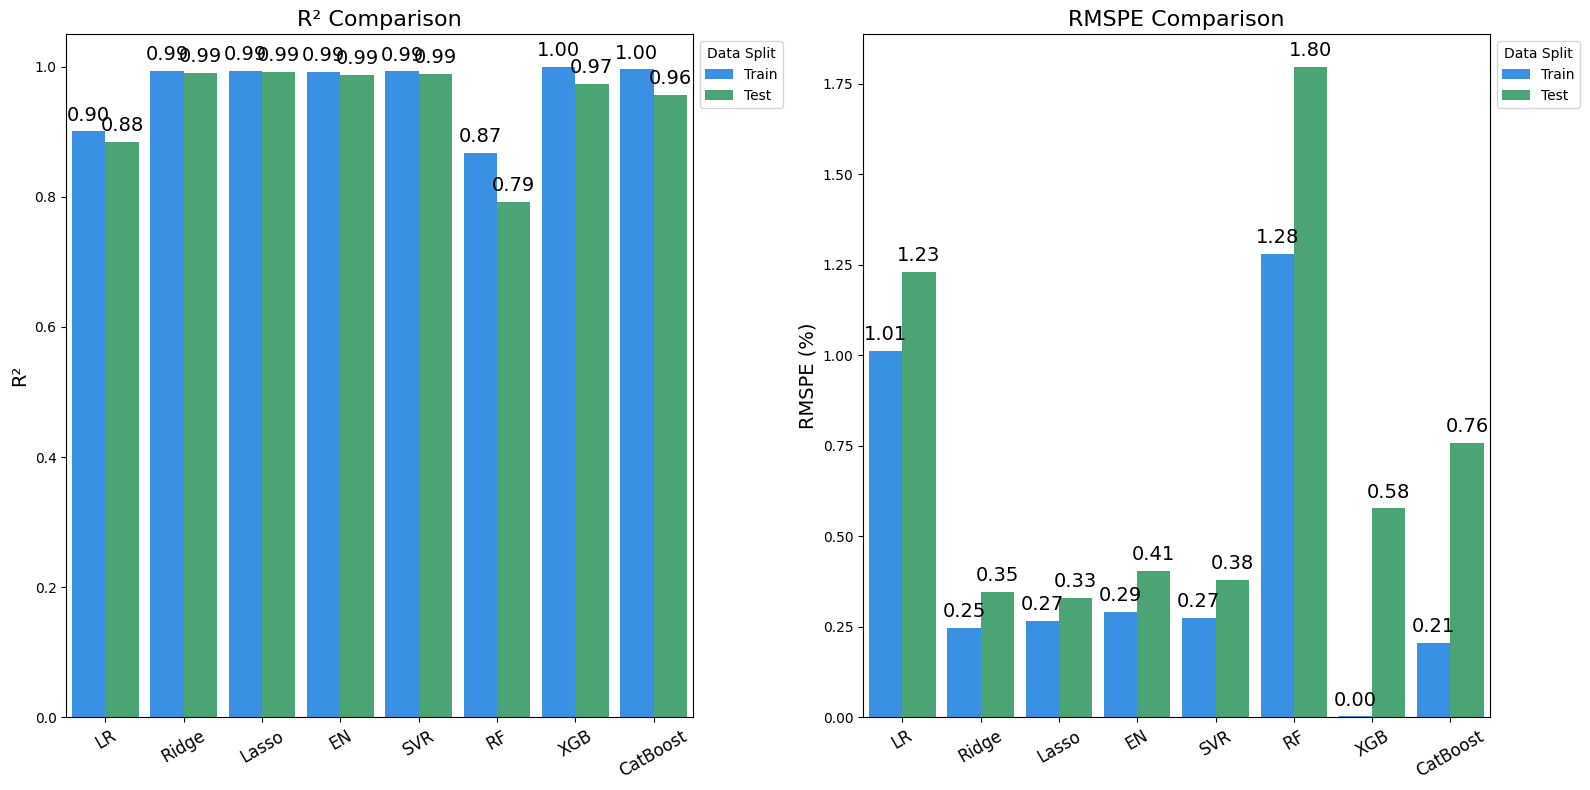

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def plot_model_performance(model_performance_df):
    # Melt the DataFrame for Train and Test metrics side-by-side
    performance_melted = model_performance_df.melt(
        id_vars="Model",
        value_vars=['Train_R2', 'Test_R2', 'Train_RMSPE', 'Test_RMSPE'],
        var_name="Metric",
        value_name="Score"
    )

    # Create columns for Data Split (Train/Test) and Metric Type (R²/RMSPE)
    performance_melted['Data Split'] = performance_melted['Metric'].apply(
        lambda x: 'Train' if 'Train' in x else 'Test')
    performance_melted['Metric Type'] = performance_melted['Metric'].apply(
        lambda x: 'R²' if 'R2' in x else 'RMSPE')

    # Set up figure and axes for two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1.5, 1.5]})

    # Define a blue-green color palette
    palette = {'Train': 'dodgerblue', 'Test': 'mediumseagreen'}

    # Plot R² Comparison
    barplot_r2 = sns.barplot(
        data=performance_melted[performance_melted['Metric Type'] == 'R²'],
        x='Model', y='Score', hue='Data Split', ax=axes[0],
        palette=palette, dodge=True, width=0.85
    )
    axes[0].set_title('R² Comparison', fontsize=16)
    axes[0].set_ylabel('R²', fontsize=14)
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', labelsize=12)

    # Add value labels to each bar in R² plot
    for bar in barplot_r2.containers:
        labels = [f"{x:.2f}" for x in bar.datavalues]
        barplot_r2.bar_label(bar, labels=labels, label_type='edge', padding=5, fontsize=14, color='black')

    axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='center', rotation=30)

    # Plot RMSPE Comparison
    barplot_rmspe = sns.barplot(
        data=performance_melted[performance_melted['Metric Type'] == 'RMSPE'],
        x='Model', y='Score', hue='Data Split', ax=axes[1],
        palette=palette, dodge=True, width=0.85
    )
    axes[1].set_title('RMSPE Comparison', fontsize=16)
    axes[1].set_ylabel('RMSPE (%)', fontsize=14)
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', labelsize=12)

    # Add value labels to each bar in RMSPE plot
    for bar in barplot_rmspe.containers:
        labels = [f"{x:.2f}" for x in bar.datavalues]
        barplot_rmspe.bar_label(bar, labels=labels, label_type='edge', padding=5, fontsize=14, color='black')

    axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='center', rotation=30)

    # Adjust layout and spacing between subplots
    plt.subplots_adjust(wspace=0.85)

    # Customize Legend Size and Placement
    handles, labels = barplot_r2.get_legend_handles_labels()
    barplot_r2.legend(handles, ['Train', 'Test'], title='Data Split',
                      fontsize=10, title_fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    barplot_rmspe.legend(handles, ['Train', 'Test'], title='Data Split',
                         fontsize=10, title_fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()



# Call the function to plot model performance comparison
plot_model_performance(model_performance_df)


# K-Fold Cross Validation


In [58]:
# K-Fold Cross Validation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer

def evaluate_model_with_cv(model, X, y, model_name, k=5):
    def custom_rmspe(y_true, y_pred):
        epsilon = 1e-10
        return np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + epsilon)))) * 100

    rmspe_scorer = make_scorer(custom_rmspe, greater_is_better=False)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmspe_scores = cross_val_score(model, X, y, cv=kf, scoring=rmspe_scorer)

    print(f"\nModel: {model_name} - {k}-Fold Cross Validation")
    print(f"R^2 scores for each fold: {r2_scores}")
    print(f"Average R^2: {np.mean(r2_scores):.4f}")

    print(f"RMSPE scores for each fold: {-rmspe_scores}")
    print(f"Average RMSPE: {-np.mean(rmspe_scores):.2f}%")

In [59]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

models = [
    (Ridge(), "Ridge Regression"),
    (Lasso(), "Lasso Regression"),
    (ElasticNet(), "ElasticNet Regression"),
    (SVR(), "Support Vector Regression"),
    (DecisionTreeRegressor(random_state=0), "Decision Tree"),
    (RandomForestRegressor(random_state=0), "Random Forest"),
    (XGBRegressor(random_state=0, verbosity=0), "XGBoost")
]

for model, name in models:
    evaluate_model_with_cv(model, X, y, name, k=5)



Model: Ridge Regression - 5-Fold Cross Validation
R^2 scores for each fold: [0.99591231 0.98774829 0.99405122 0.9914772  0.9901825 ]
Average R^2: 0.9919
RMSPE scores for each fold: [0.2877187  0.29767836 0.2976982  0.25967294 0.28276332]
Average RMSPE: 0.29%

Model: Lasso Regression - 5-Fold Cross Validation
R^2 scores for each fold: [0.99277521 0.9811219  0.99680114 0.98790307 0.98787334]
Average R^2: 0.9893
RMSPE scores for each fold: [0.38778325 0.37005629 0.21302877 0.30740427 0.31436417]
Average RMSPE: 0.32%

Model: ElasticNet Regression - 5-Fold Cross Validation
R^2 scores for each fold: [0.99422705 0.98130724 0.99622891 0.98853748 0.98789121]
Average R^2: 0.9896
RMSPE scores for each fold: [0.34232332 0.3683506  0.23531027 0.29941385 0.31421397]
Average RMSPE: 0.31%

Model: Support Vector Regression - 5-Fold Cross Validation
R^2 scores for each fold: [-0.31172944  0.24752503 -0.05107082  0.25098564  0.213057  ]
Average R^2: 0.0698
RMSPE scores for each fold: [5.48403905 2.38280

# SHAP explainability


Calculating SHAP for Lasso...

Calculating SHAP for Ridge...

Calculating SHAP for EN...

Calculating SHAP for RF...

Calculating SHAP for SVR...


  0%|          | 0/40 [00:00<?, ?it/s]


Calculating SHAP for XGB...


PermutationExplainer explainer: 41it [00:25,  1.15it/s]                        



Calculating SHAP for CB...


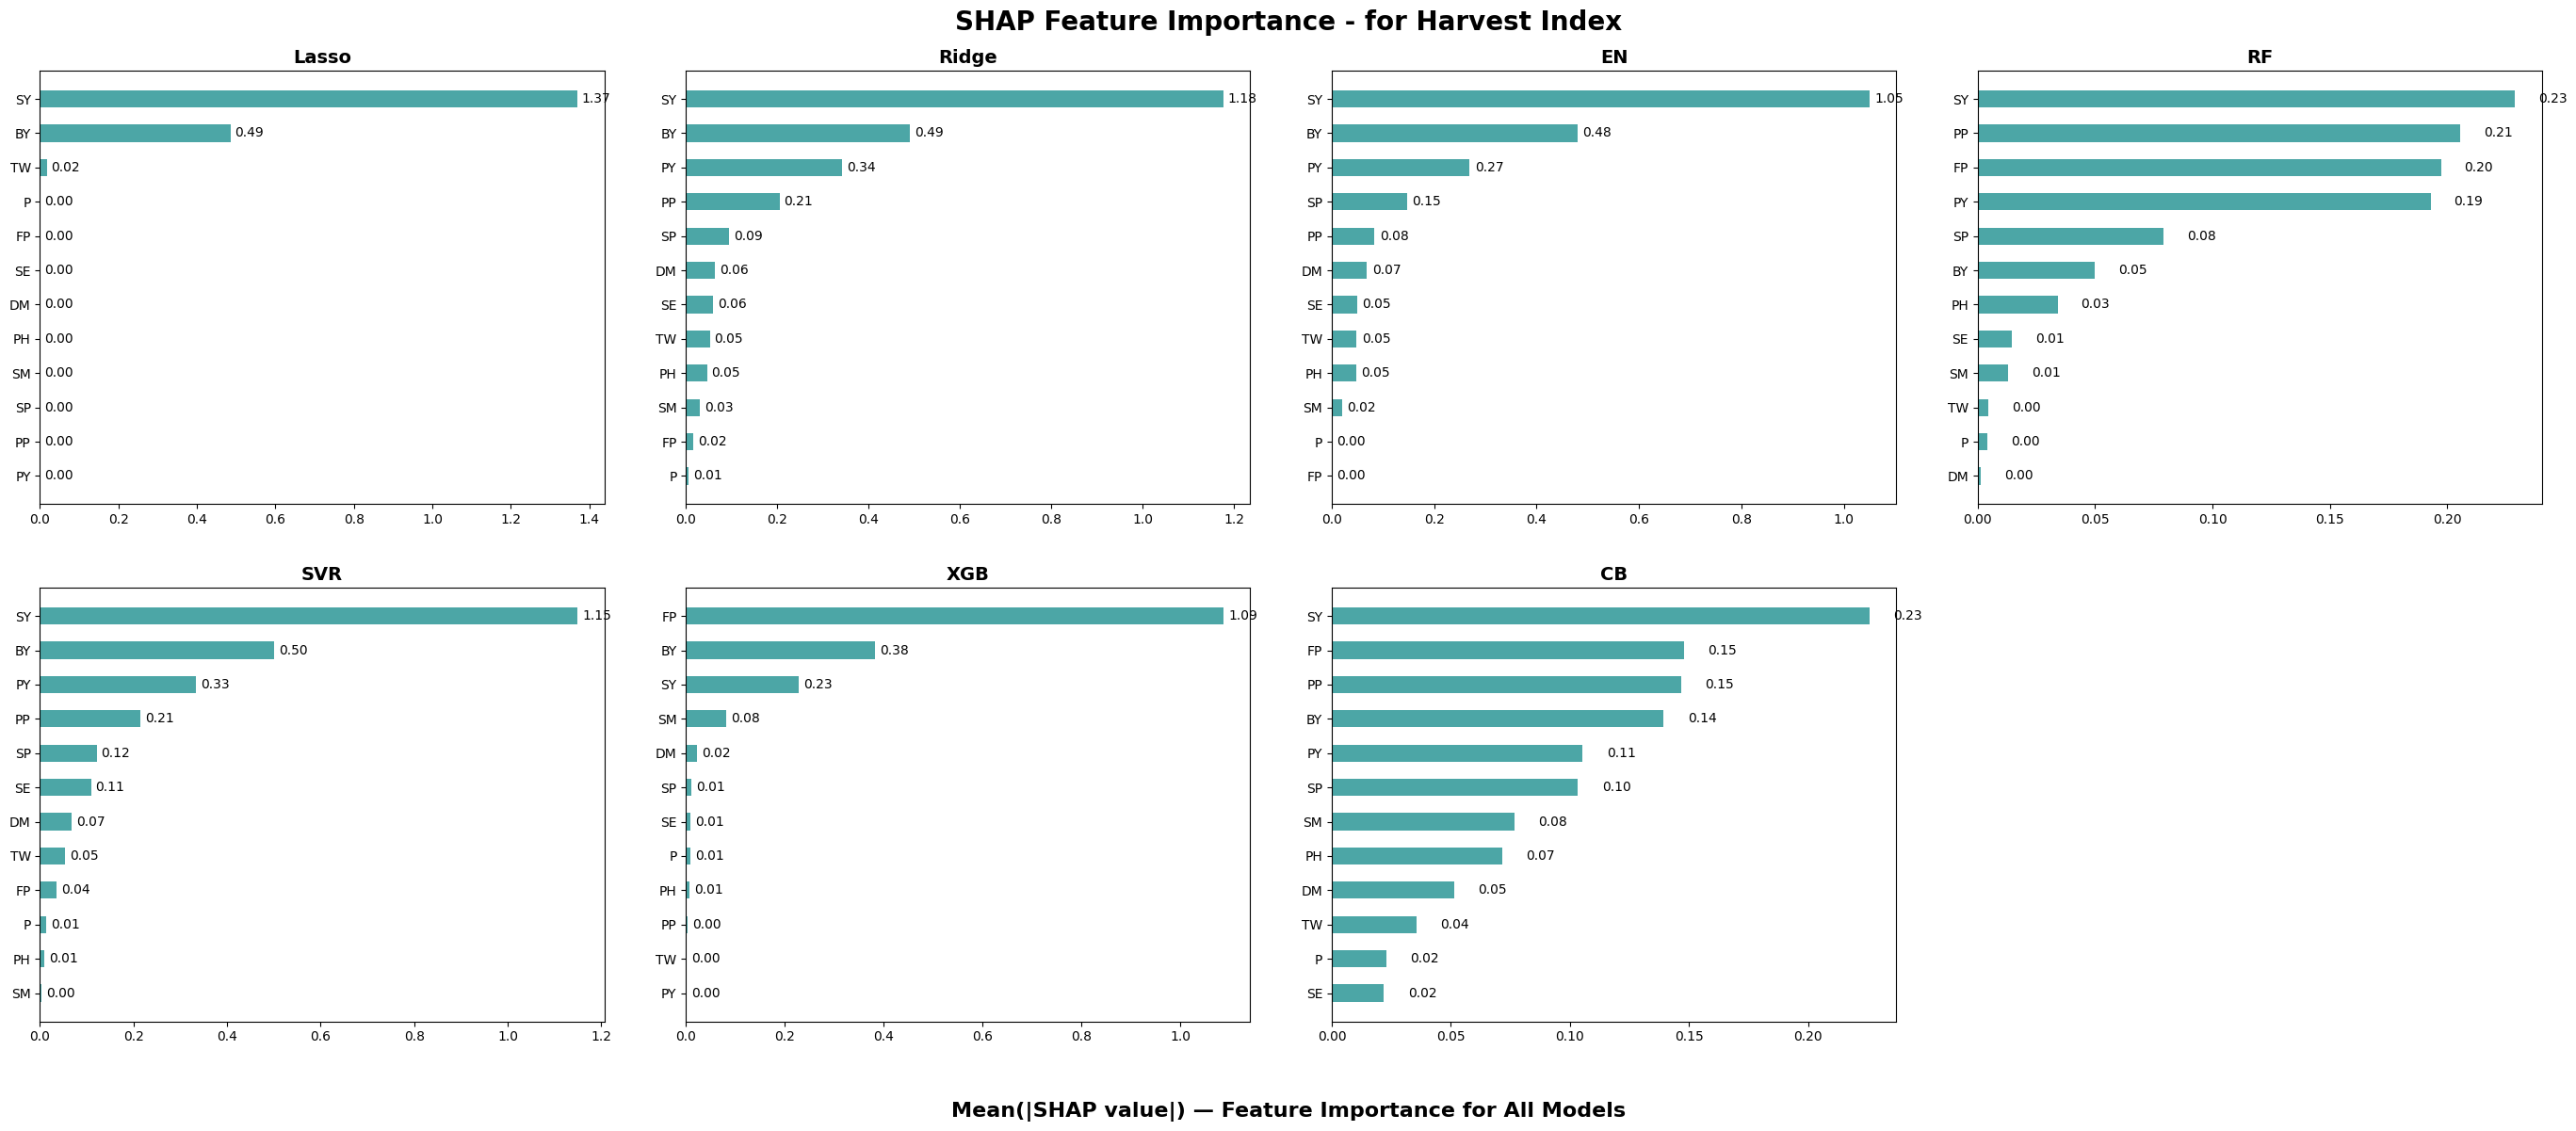

In [68]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Feature names
# -------------------------------
feature_names = [
    'P', 'FP', 'SE','DM', 'PH', 'SM', 'SP', 'TW', 'SY', 'BY', 'PP', 'PY'
]

# -------------------------------
# Models
# -------------------------------
models = {
    'Lasso': lasso_reg.best_estimator_,
    'Ridge': ridge_reg.best_estimator_,
    'EN': elastic_net_reg.best_estimator_,
    'RF': rf_reg.best_estimator_,
    'SVR': svr_reg.best_estimator_,
    'XGB': xgb_reg.best_estimator_,
    'CB': catboost_reg.best_estimator_,
}

model_names = list(models.keys())

# -------------------------------
# Figure setup
# -------------------------------
fig, axes = plt.subplots(2, 4, figsize=(28, 12))
axes = axes.flatten()

for i, name in enumerate(model_names):
    model = models[name]
    print(f"\nCalculating SHAP for {name}...")

    # --- Select suitable explainer ---
    if name in ['RF', 'CB']:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_test)
        vals = shap_values.values

    elif name == 'XGB':
        # Handle XGBoost dart booster using general Explainer
        explainer = shap.Explainer(model.predict, X_test)
        shap_values = explainer(X_test)
        vals = shap_values.values

    elif name in ['Lasso', 'Ridge', 'EN']:
        explainer = shap.LinearExplainer(model, X_test)
        shap_values = explainer(X_test)
        vals = shap_values.values

    else:  # SVR or others
        X_sample = shap.sample(X_test, 100)
        explainer = shap.KernelExplainer(model.predict, X_sample)
        shap_values = explainer.shap_values(X_test[:100])
        vals = np.array(shap_values)

    # --- Compute mean absolute SHAP values ---
    mean_abs_shap = np.abs(vals).mean(axis=0)

    sorted_idx = np.argsort(-mean_abs_shap[:X_test.shape[1]])
    sorted_features = [feature_names[j] for j in sorted_idx]
    sorted_values = mean_abs_shap[sorted_idx]

    # --- Plot bar chart ---
    bars = axes[i].barh(sorted_features, sorted_values, color='teal', alpha=0.7, height=0.5)
    axes[i].invert_yaxis()
    axes[i].set_title(name, fontsize=14, weight='bold')
    axes[i].tick_params(axis='both', labelsize=10)

    # Add SHAP value labels
    for bar, val in zip(bars, sorted_values):
        axes[i].text(val + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.2f}",
                     va='center', fontsize=10)

# Remove empty subplot (8th)
fig.delaxes(axes[-1])

# Shared caption
fig.text(0.5, 0.02, 'Mean(|SHAP value|) — Feature Importance for All Models',
         ha='center', fontsize=16, weight='bold')

plt.tight_layout(pad=3.0, rect=[0, 0.05, 1, 1])
plt.suptitle("SHAP Feature Importance - for Harvest Index", fontsize=20, weight='bold', y=1)
plt.show()


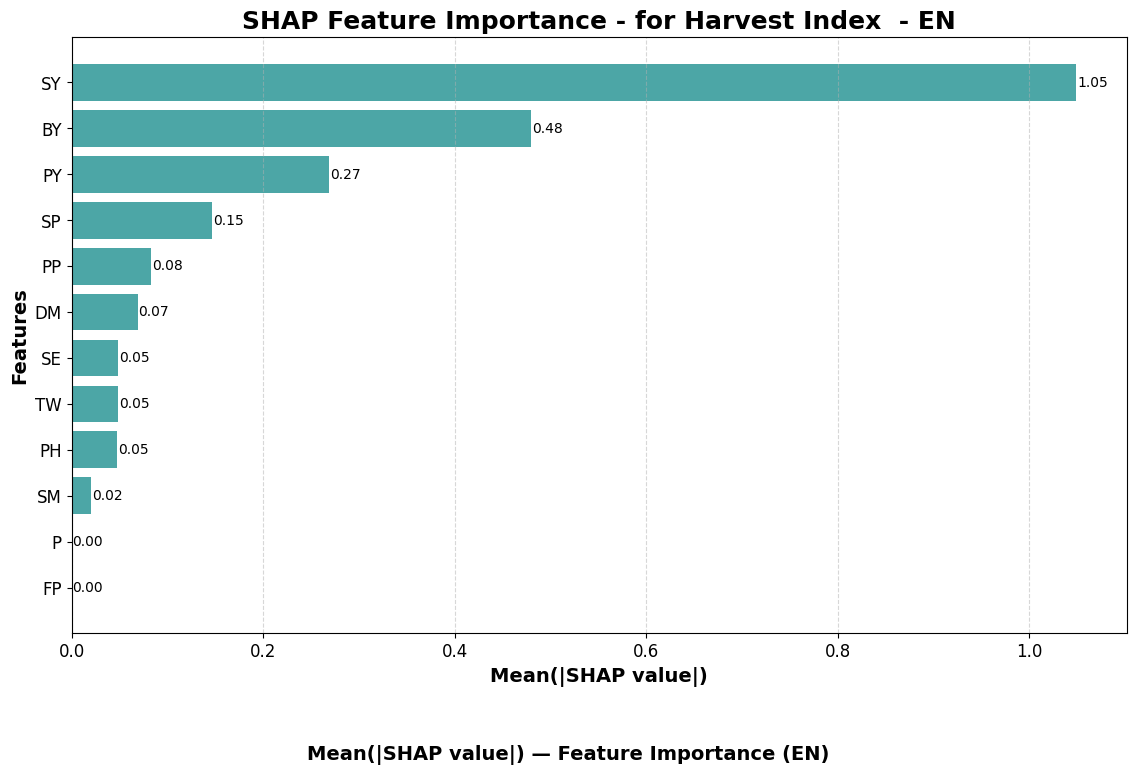

In [61]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Real feature names
# -------------------------------
feature_names = [
    'P', 'FP', 'SE','DM', 'PH', 'SM', 'SP', 'TW', 'SY', 'BY', 'PP', 'PY'
]
# -------------------------------
# Best model
# -------------------------------
best_model_name = 'EN' 
best_model = models[best_model_name]

# -------------------------------
# SHAP explainer
# -------------------------------
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# -------------------------------
# Calculate mean absolute SHAP values
# -------------------------------
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(-mean_abs_shap[:X_test.shape[1]])  # descending
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_values = mean_abs_shap[sorted_idx]

# -------------------------------
# Plot
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(sorted_features, sorted_values, color='teal', alpha=0.7)

# Flip y-axis so most important on top
ax.invert_yaxis()

# Add SHAP value labels next to bars (2 decimals)
for bar, val in zip(bars, sorted_values):
    ax.text(val + 0.001, bar.get_y() + bar.get_height()/2, 
            f"{val:.2f}", va='center', fontsize=10)

# Styling
ax.set_xlabel("Mean(|SHAP value|)", fontsize=14, weight='bold')
ax.set_ylabel("Features", fontsize=14, weight='bold')
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Shared caption
fig.text(0.5, 0.01, f'Mean(|SHAP value|) — Feature Importance ({best_model_name})', 
         ha='center', fontsize=14, weight='bold')

# Title
plt.title(f"SHAP Feature Importance - for Harvest Index  - {best_model_name}", fontsize=18, weight='bold')

plt.tight_layout(pad=3.0, rect=[0, 0.05, 1, 1])
plt.show()
